# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_1886270/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [11]:
protocol_name = "rc_om_and_comp"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = "./data"

In [13]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [22]:
raw_data_glob_pattern = "./data/spikegadgets/"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [23]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [24]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [25]:
raw_data_file_path

'./data/spikegadgets/'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [26]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subj_6_3/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subj_6_3/data/spikegadgets/20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.mountainsort/20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.group0.mda
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subj_6_3/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subj_6_3/data/spikegadge

file prefix: group0.coordinates.dat
directory prefix: mountainsort
file prefix: dio_ECU_Dout28.dat
directory prefix: DIO
file prefix: dio_ECU_Din16.dat
directory prefix: DIO
file prefix: dio_ECU_Dout5.dat
directory prefix: DIO
file prefix: dio_ECU_Din7.dat
directory prefix: DIO
file prefix: dio_ECU_Din27.dat
directory prefix: DIO
file prefix: dio_Controller_Din1.dat
directory prefix: DIO
file prefix: dio_ECU_Din25.dat
directory prefix: DIO
file prefix: dio_ECU_Dout25.dat
directory prefix: DIO
file prefix: dio_Controller_Din4.dat
directory prefix: DIO
file prefix: dio_ECU_Din26.dat
directory prefix: DIO
file prefix: dio_ECU_Din8.dat
directory prefix: DIO
file prefix: dio_ECU_Dout31.dat
directory prefix: DIO
file prefix: dio_ECU_Din2.dat
directory prefix: DIO
file prefix: dio_ECU_Din20.dat
directory prefix: DIO
file prefix: dio_ECU_Dout11.dat
directory prefix: DIO
file prefix: dio_ECU_Dout2.dat
directory prefix: DIO
file prefix: dio_ECU_Din23.dat
directory prefix: DIO
file prefix: dio_EC

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subj_6_3/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subj_6_3/data/spikegadgets/20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.kilosort/20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: LFP_nt24ch1.dat
directory prefix: LFP
file prefix: LFP_nt20ch1.dat
directory prefix: LFP
file prefix: LFP_nt32ch1.dat
directory prefix: LFP
file prefix: LFP_nt31ch1.dat
directory prefix: LFP
file prefix: LFP_nt10ch1.dat
directory prefix: LFP
file prefix: LFP_nt14ch1.dat
directory prefix: LFP
file prefix: LFP_nt16ch1.dat
directory prefix: LFP
file prefix: LFP_nt8ch1.dat
directory prefix: LFP
file prefix: LFP_nt29ch1.dat
directory prefix: LFP
file prefix: LFP_nt7ch1.dat
directory prefix: LFP
file prefix: LFP_nt21ch1.dat
directory prefix: LFP
file prefix: timestamps.dat
directory prefix: LFP
file prefix: LFP_nt11ch1.dat
directory prefix: LFP
file prefix: LFP_nt3ch1.dat
directory prefix: LFP
file prefix: LFP_nt15ch1.dat
directory prefix: LFP
file prefix: LFP_nt12ch1.dat
directory prefix: LFP
file prefix: LFP_nt1ch1.dat
directory prefix: LFP
file prefix: LFP_nt25ch1.dat
directory prefix: LFP
file prefix: LFP_nt27ch1.dat
directory prefix: LFP
file prefix: LFP_nt4ch1.dat
director

- All the folders that were extracted from

In [27]:
file_to_data.keys()

dict_keys(['20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.mountainsort', 'mountainsort', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.DIO', 'DIO', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.timestampoffset', '.', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.stimulation', 'stimulation', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.spikeband', 'spikeband', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.spikes', 'spikes', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.raw', 'raw', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.kilosort', 'kilosort', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.LFP', 'LFP', '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.analog', 'analog'])

- Looking over all the extracted data

In [28]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: 20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.mountainsort
	File Name: group0.coordinates.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: Pad locations in microns

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.3.2

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Apr 12 2022

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 15:21:02

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 6.2.2

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/

# Part 2: Looking over the data

## Looking over the MED-PC Data

- Box 1 Port Entries
    - ECU Din3
- Box 2 Port Entries
    - Controller Din1
- Box 1 Tone playing
    - ECU Din1

In [29]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [30]:
DIO_directory_name

'DIO'

In [31]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [32]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout28.dat', 'dio_ECU_Din16.dat', 'dio_ECU_Dout5.dat', 'dio_ECU_Din7.dat', 'dio_ECU_Din27.dat', 'dio_Controller_Din1.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Dout25.dat', 'dio_Controller_Din4.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Din8.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Din2.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Dout11.dat', 'dio_ECU_Dout2.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Din1.dat', 'dio_ECU_Dout6.dat', 'dio_ECU_Dout15.dat', 'dio_ECU_Dout9.dat', 'dio_ECU_Dout1.dat', 'dio_ECU_Din29.dat', 'dio_ECU_Dout14.dat', 'dio_Controller_Din7.dat', 'dio_ECU_Din15.dat', 'dio_ECU_Din28.dat', 'dio_ECU_Dout8.dat', 'dio_ECU_Dout27.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Din17.dat', 'dio_ECU_Dout18.dat', 'dio_ECU_Din30.dat', 'dio_ECU_Dout12.dat', 'dio_ECU_Din5.dat', 'dio_ECU_Dout23.dat', 'dio_ECU_Din4.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Din31.dat', 'dio_ECU_Din32.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Dout7.dat', 'dio_ECU_Din18.dat', 'dio_ECU_Din12.d

### Tone Onset Signal

In [33]:
tone_onset_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [34]:
tone_onset_DIN_file_name

'dio_ECU_Din1.dat'

In [35]:
tone_onset_DIN_state_array = DIO_directory_dict[tone_onset_DIN_file_name]["data"]

In [36]:
tone_onset_DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4359951, 1), ( 4559950, 0),
       ( 5959954, 1), ( 6159948, 0), ( 7759946, 1), ( 7959946, 0),
       ( 9359945, 1), ( 9559944, 0), (10859943, 1), (11059942, 0),
       (12859940, 1), (13059938, 0), (14759938, 1), (14959938, 0),
       (16559934, 1), (16759938, 0), (18159935, 1), (18359934, 0),
       (19959932, 1), (20159930, 0), (21959930, 1), (22159930, 0),
       (23759929, 1), (23959928, 0), (26159926, 1), (26359925, 0),
       (27959924, 1), (28159923, 0), (28359523, 1), (29750102, 0),
       (30950500, 1), (31150501, 0), (32550496, 1), (32750498, 0),
       (34350494, 1), (34550497, 0), (35950496, 1), (36150495, 0),
       (37450494, 1), (37650493, 0), (39450491, 1), (39650491, 0),
       (41350489, 1), (41550489, 0), (43150487, 1), (43350488, 0),
       (44750483, 1), (44950483, 0), (46550484, 1), (46750484, 0),
       (48550482, 1), (48750479, 0), (50350480, 1), (50550479, 0),
       (52750475, 1), (52950477, 0), (54550473, 1), (54750475,

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

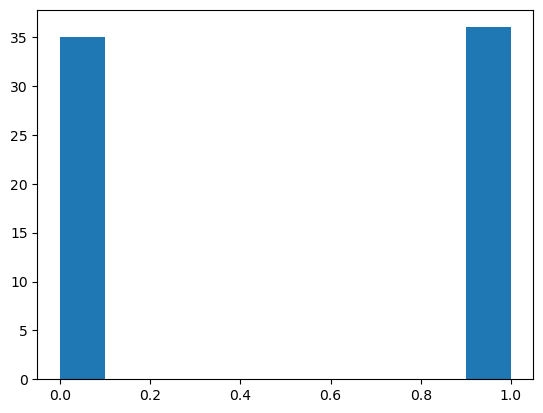

In [37]:
plt.hist([tup[1] for tup in tone_onset_DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

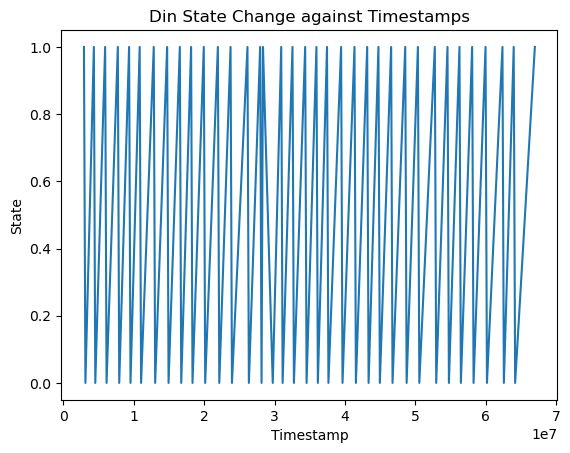

In [38]:
plt.plot([tup[0] for tup in tone_onset_DIN_state_array], [tup[1] for tup in tone_onset_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 1 Port Entries

In [39]:
box1_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din3.dat", return_first=True)

In [40]:
box1_port_entries_DIN_file_name

'dio_ECU_Din3.dat'

In [41]:
box1_port_entries_DIN_state_array = DIO_directory_dict[box1_port_entries_DIN_file_name]["data"]

In [42]:
box1_port_entries_DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4064951, 1), ..., (66884062, 1),
       (66900862, 0), (66950060, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([1399.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

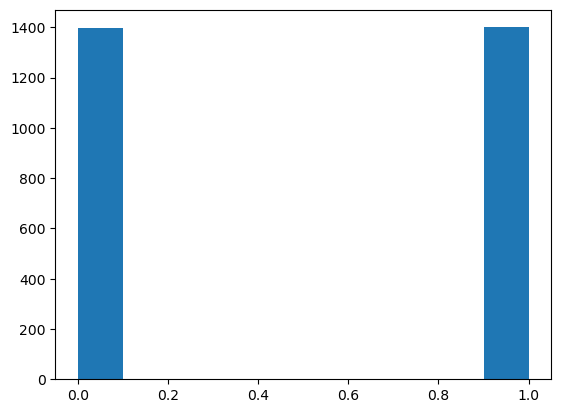

In [43]:
plt.hist([tup[1] for tup in box1_port_entries_DIN_state_array])

- There is a gap in the middle when the protocol was being changed between competition or omission

Text(0.5, 1.0, 'Din State Change against Timestamps')

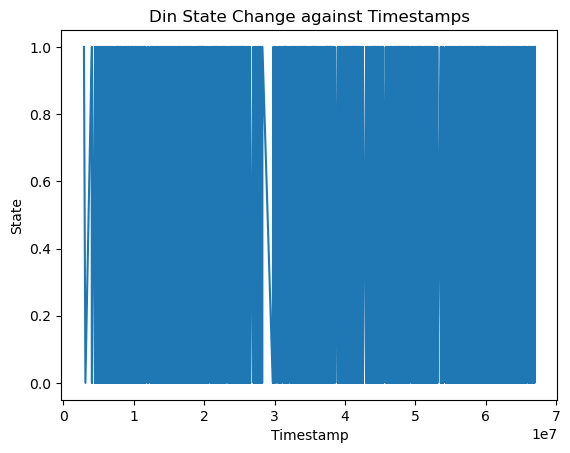

In [44]:
plt.plot([tup[0] for tup in box1_port_entries_DIN_state_array], [tup[1] for tup in box1_port_entries_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 2 Port Entries

In [45]:
box2_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="dio_Controller_Din1.dat", return_first=True)

In [46]:
box2_port_entries_DIN_file_name

'dio_Controller_Din1.dat'

In [47]:
box2_port_entries_DIN_file_name = DIO_directory_dict[box2_port_entries_DIN_file_name]["data"]

In [48]:
box2_port_entries_DIN_file_name

array([( 2951903, 1), ( 3159548, 0), ( 4484546, 1), ( 4512348, 0),
       ( 4513746, 1), ( 4515548, 0), ( 4516748, 1), ( 4541148, 0),
       ( 4541548, 1), ( 4543948, 0), ( 4944948, 1), ( 4964948, 0),
       ( 4965545, 1), ( 4976148, 0), ( 5109345, 1), ( 5110350, 0),
       ( 5110945, 1), ( 5127545, 0), ( 5183947, 1), ( 5202147, 0),
       ( 5420747, 1), ( 5505945, 0), ( 5921547, 1), ( 5952949, 0),
       ( 5996946, 1), ( 5998546, 0), ( 6001546, 1), ( 6008544, 0),
       ( 6012546, 1), ( 6013546, 0), ( 6014349, 1), ( 6026946, 0),
       ( 6032746, 1), ( 6033746, 0), ( 6035344, 1), ( 6274746, 0),
       ( 6454746, 1), ( 6491546, 0), ( 6687346, 1), ( 6714343, 0),
       ( 6747343, 1), ( 6749146, 0), ( 6749546, 1), ( 6753146, 0),
       ( 7020545, 1), ( 7042745, 0), ( 7146745, 1), ( 7178145, 0),
       ( 7482945, 1), ( 7511142, 0), ( 7720144, 1), ( 7745542, 0),
       ( 7760944, 1), ( 7762744, 0), ( 7766744, 1), ( 7775544, 0),
       ( 7782144, 1), ( 7796144, 0), ( 7801944, 1), ( 7802944,

(array([485.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 486.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

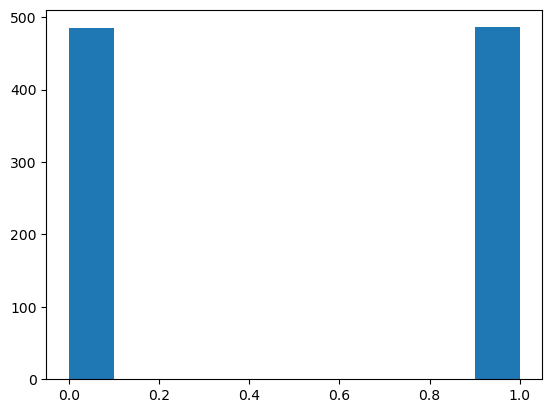

In [49]:
plt.hist([tup[1] for tup in box2_port_entries_DIN_file_name])

- This is half the time than the previous port entries, because the mouse was moved to box 1 for half of the session

Text(0.5, 1.0, 'Din State Change against Timestamps')

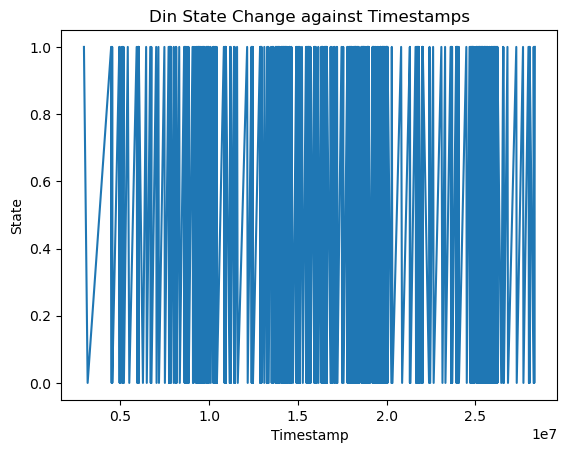

In [50]:
plt.plot([tup[0] for tup in box2_port_entries_DIN_file_name], [tup[1] for tup in box2_port_entries_DIN_file_name])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

## Labeling the Tone and Port Entries

# Syncing with MED-PC

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [51]:
tone_onset_DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4359951, 1), ( 4559950, 0),
       ( 5959954, 1), ( 6159948, 0), ( 7759946, 1), ( 7959946, 0),
       ( 9359945, 1), ( 9559944, 0), (10859943, 1), (11059942, 0),
       (12859940, 1), (13059938, 0), (14759938, 1), (14959938, 0),
       (16559934, 1), (16759938, 0), (18159935, 1), (18359934, 0),
       (19959932, 1), (20159930, 0), (21959930, 1), (22159930, 0),
       (23759929, 1), (23959928, 0), (26159926, 1), (26359925, 0),
       (27959924, 1), (28159923, 0), (28359523, 1), (29750102, 0),
       (30950500, 1), (31150501, 0), (32550496, 1), (32750498, 0),
       (34350494, 1), (34550497, 0), (35950496, 1), (36150495, 0),
       (37450494, 1), (37650493, 0), (39450491, 1), (39650491, 0),
       (41350489, 1), (41550489, 0), (43150487, 1), (43350488, 0),
       (44750483, 1), (44950483, 0), (46550484, 1), (46750484, 0),
       (48550482, 1), (48750479, 0), (50350480, 1), (50550479, 0),
       (52750475, 1), (52950477, 0), (54550473, 1), (54750475,

- Checking to see if 1 or 0 is when the tone plays
    - Dividing by 20000, because we are recording at a sampling rate at 20000

In [52]:
tone_onset_DIN_state_array[0][0]

2951903

In [53]:
tone_onset_DIN_state_array[1][0]

3159550

In [54]:
tone_onset_DIN_state_array[2][0]

4359951

- So the tone starts when the state is "1"
    - This can be seen because the time from 1 to 0 is 10 seconds

In [55]:
(tone_onset_DIN_state_array[1][0] - tone_onset_DIN_state_array[0][0]) / 20000

10.38235

- So the tone starts when the state is "2"
    - This can be seen because the time from 0 to 1 is 60 seconds, the time for one session

In [56]:
(tone_onset_DIN_state_array[2][0] - tone_onset_DIN_state_array[1][0]) / 20000

60.02005

- Getting only the times when the ECU signal was on

In [57]:
tone_din_time = [din_time for din_time, din_state in tone_onset_DIN_state_array if din_state == 1]

In [58]:
len(tone_din_time)

36

In [59]:
tone_din_time[:10]

[2951903,
 4359951,
 5959954,
 7759946,
 9359945,
 10859943,
 12859940,
 14759938,
 16559934,
 18159935]

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [60]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [61]:
raw_directory_dict.keys()

dict_keys(['raw_group0.dat', 'timestamps.dat', 'group0.coordinates.dat'])

In [62]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [63]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00133',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1671040463872',
 'timestamp_at_creation': '877254',
 'first_timestamp': '2951903',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([ -405,  -355,  -354,  -469,  -636,  -364,  -544,  -376,  -619,  -525,  -644,  -750,  -497,  -707,  -902,  -131, -1047,  -598, -1538, -1356,  -587

- Array of Voltages for each channel

In [64]:
voltage_value_array = raw_recording_fields_text["data"]

In [65]:
voltage_value_array.shape

(64120026,)

In [66]:
voltage_value_array[:5]

array([([ -405,  -355,  -354,  -469,  -636,  -364,  -544,  -376,  -619,  -525,  -644,  -750,  -497,  -707,  -902,  -131, -1047,  -598, -1538, -1356,  -587,  -428,  -198,  -571,  -226,  -411,  -246,  -130,  -173,  -328,  -692,  -621],),
       ([ -467,  -391,  -487,  -549,  -656,  -401,  -615,  -482,  -685,  -557,  -674,  -884,  -481,  -682,  -959,  -164, -1104,  -655, -1532, -1428,  -676,  -448,  -154,  -521,  -337,  -331,  -326,  -172,  -180,  -367,  -686,  -639],),
       ([ -563,  -379,  -380,  -545,  -633,  -413,  -570,  -548,  -748,  -594,  -605,  -753,  -503,  -620,  -974,  -107, -1044,  -604, -1520, -1418,  -675,  -498,  -150,  -419,  -316,  -353,  -141,   -95,  -181,  -352,  -646,  -699],),
       ([ -458,  -292,  -337,  -498,  -536,  -400,  -534,  -463,  -765,  -698,  -712,  -740,  -491,  -632,  -917,   -96, -1103,  -664, -1536, -1391,  -641,  -538,  -138,  -682,  -407,  -404,  -193,  -165,  -200,  -395,  -665,  -780],),
       ([ -532,  -375,  -521,  -568,  -664,  -471,  -641

- Voltage Time Stamps

In [67]:
raw_directory_dict.keys()

dict_keys(['raw_group0.dat', 'timestamps.dat', 'group0.coordinates.dat'])

In [68]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [69]:
voltage_timestamp_array[:5]

array([(2951903,), (2951904,), (2951905,), (2951906,), (2951907,)],
      dtype=[('time', '<u4')])

In [70]:
voltage_timestamp_array[-5:]

array([(67071924,), (67071925,), (67071926,), (67071927,), (67071928,)],
      dtype=[('time', '<u4')])

In [71]:
voltage_timestamp_array.shape

(64120026,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [72]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [73]:
voltage_timestamp_array[:5]

array([2951903, 2951904, 2951905, 2951906, 2951907])

In [74]:
voltage_timestamp_array[-5:]

array([67071924, 67071925, 67071926, 67071927, 67071928])

In [75]:
voltage_timestamp_array.shape

(64120026,)

- Because spike sorting is 0-indexed, we must make all the tone time also 0-indexed. We will do this by subtracting the first index from the ephys recording for all the tone times.

In [76]:
all_tone_unit_time = [tone_unit_time - voltage_timestamp_array[0] for tone_unit_time in tone_din_time]

In [77]:
all_tone_unit_time

[0,
 1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 25407620,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563,
 63998157]

- Checking to see what the time looks like for each tone. The first one is 0, so can be ignored. The last one can also be ignored because it's different by a smaller time than the time between tones compared to the previous one 

In [78]:
[x / 20000 for x in all_tone_unit_time]

[0.0,
 70.4024,
 150.40255,
 240.40215,
 320.4021,
 395.402,
 495.40185,
 590.40175,
 680.40155,
 760.4016,
 850.40145,
 950.40135,
 1040.4013,
 1160.40115,
 1250.40105,
 1270.381,
 1399.92985,
 1479.92965,
 1569.92955,
 1649.92965,
 1724.92955,
 1824.9294,
 1919.9293,
 2009.9292,
 2089.929,
 2179.92905,
 2279.92895,
 2369.92885,
 2489.9286,
 2579.9285,
 2664.9284,
 2754.9283,
 2849.9282,
 2969.9282,
 3049.92815,
 3199.90785]

- So we must remove first and last instance because they are just the start and stop of the program and not the actual tone

In [79]:
all_tone_unit_time = all_tone_unit_time[1:-1]

In [80]:
all_tone_unit_time

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 25407620,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

In [81]:
len(all_tone_unit_time)

34

## Seeing which tone belongs to reward training vs competition

- ITI times from MED-PC
    - 60 was not part of the list, but it is the inital delay of the tone from the start of the program

In [82]:
iti_times = [60, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]

- The number of reward trials and competition trials(along with what minute each happened)

```
Reward Trials
    0:       57.000
     1:       58.000
     2:        0.000
     3:        1.000
     4:        2.000
     5:        4.000
     6:        6.000
     7:        7.000
     8:        8.000
     9:       10.000
    10:       12.000
    11:       13.000
    12:       15.000
    13:       17.000
Competition Trials
     0:       19.000
     1:       20.000
     2:       22.000
     3:       23.000
     4:       24.000
     5:       26.000
     6:       28.000
     7:       29.000
     8:       31.000
     9:       32.000
    10:       34.000
    11:       35.000
    12:       37.000
    13:       39.000
    14:       40.000
    15:       42.000
    16:       43.000
    17:       45.000
    18:       47.000
```

In [83]:
previous_time = 0
for index, (time) in enumerate(all_tone_unit_time):
    print("Current Index: {} Current Time: {} Time Difference: {}".format(index, time, (time - previous_time) / 20000))
    previous_time = time

Current Index: 0 Current Time: 1408048 Time Difference: 70.4024
Current Index: 1 Current Time: 3008051 Time Difference: 80.00015
Current Index: 2 Current Time: 4808043 Time Difference: 89.9996
Current Index: 3 Current Time: 6408042 Time Difference: 79.99995
Current Index: 4 Current Time: 7908040 Time Difference: 74.9999
Current Index: 5 Current Time: 9908037 Time Difference: 99.99985
Current Index: 6 Current Time: 11808035 Time Difference: 94.9999
Current Index: 7 Current Time: 13608031 Time Difference: 89.9998
Current Index: 8 Current Time: 15208032 Time Difference: 80.00005
Current Index: 9 Current Time: 17008029 Time Difference: 89.99985
Current Index: 10 Current Time: 19008027 Time Difference: 99.9999
Current Index: 11 Current Time: 20808026 Time Difference: 89.99995
Current Index: 12 Current Time: 23208023 Time Difference: 119.99985
Current Index: 13 Current Time: 25008021 Time Difference: 89.9999
Current Index: 14 Current Time: 25407620 Time Difference: 19.97995
Current Index: 15

1. To get the tones that correspond to the first part(training), see where the first 70(60 + 10 to include tone for first tone) occurs
    - This is index 0
2. Then get all the tones until you reach the number of training tones(14)
3. Then starting off at the last index of the first part, see where the first 70(60 + 10 to include tone for first tone) occurs again
    - This is index 32
2. Then get all the tones until you reach the number of training tones(19)

In [84]:
training_trials = all_tone_unit_time[:14]
# Skipping one because that is when the system was turned on and off when switching programs
competition_trials = all_tone_unit_time[15:]

In [85]:
training_and_competition_trials = training_trials + competition_trials

In [86]:
len(training_trials)

14

In [87]:
len(competition_trials)

19

In [88]:
len(training_and_competition_trials)

33

In [89]:
training_trials

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021]

In [90]:
competition_trials

[27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

## Categorizing Rewarded vs Omitted for Training

In [91]:
rewarded_trials = ["rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "omission", "rewarded", "rewarded"]

In [92]:
tone_to_reward = {}
for tone_time, reward_bool in zip(training_trials, rewarded_trials):
    tone_to_reward[tone_time] = reward_bool

In [93]:
tone_to_reward

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded'}

In [94]:
len(tone_to_reward)

14

## Categorizing win vs loss for competition

- Getting trial times to look over in the video

In [95]:
competition_times = [time / 20000 for time in competition_trials]

In [96]:
for index, time in enumerate(competition_times):
    print("Trial {} Minute {} Seconds {}".format(index + 1, time//60, time%60))

Trial 1 Minute 23.0 Seconds 19.929849999999988
Trial 2 Minute 24.0 Seconds 39.92965000000004
Trial 3 Minute 26.0 Seconds 9.929550000000063
Trial 4 Minute 27.0 Seconds 29.929650000000038
Trial 5 Minute 28.0 Seconds 44.92955000000006
Trial 6 Minute 30.0 Seconds 24.929399999999987
Trial 7 Minute 31.0 Seconds 59.92930000000001
Trial 8 Minute 33.0 Seconds 29.929200000000037
Trial 9 Minute 34.0 Seconds 49.92900000000009
Trial 10 Minute 36.0 Seconds 19.92905000000019
Trial 11 Minute 37.0 Seconds 59.928949999999986
Trial 12 Minute 39.0 Seconds 29.928849999999784
Trial 13 Minute 41.0 Seconds 29.928600000000188
Trial 14 Minute 42.0 Seconds 59.928499999999985
Trial 15 Minute 44.0 Seconds 24.928399999999783
Trial 16 Minute 45.0 Seconds 54.928300000000036
Trial 17 Minute 47.0 Seconds 29.928199999999833
Trial 18 Minute 49.0 Seconds 29.928199999999833
Trial 19 Minute 50.0 Seconds 49.92815000000019


- Labeled win or loss based on looking at the video

In [102]:
winning_trials = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]

In [111]:
winning_trials = ["win", "lose", "lose", "lose", "lose", "lose", "lose", "lose", "lose", "lose", "lose", "lose", "win", "win", "win", "win", "lose", "win", "win"]

In [112]:
for index, trial in enumerate(winning_trials):
    print("Trial Number: {} Win or Loss for Subject: {}".format(index + 1, trial))

Trial Number: 1 Win or Loss for Subject: win
Trial Number: 2 Win or Loss for Subject: lose
Trial Number: 3 Win or Loss for Subject: lose
Trial Number: 4 Win or Loss for Subject: lose
Trial Number: 5 Win or Loss for Subject: lose
Trial Number: 6 Win or Loss for Subject: lose
Trial Number: 7 Win or Loss for Subject: lose
Trial Number: 8 Win or Loss for Subject: lose
Trial Number: 9 Win or Loss for Subject: lose
Trial Number: 10 Win or Loss for Subject: lose
Trial Number: 11 Win or Loss for Subject: lose
Trial Number: 12 Win or Loss for Subject: lose
Trial Number: 13 Win or Loss for Subject: win
Trial Number: 14 Win or Loss for Subject: win
Trial Number: 15 Win or Loss for Subject: win
Trial Number: 16 Win or Loss for Subject: win
Trial Number: 17 Win or Loss for Subject: lose
Trial Number: 18 Win or Loss for Subject: win
Trial Number: 19 Win or Loss for Subject: win


In [113]:
tone_to_win = {}
for tone_time, win_bool in zip(competition_trials, winning_trials):
    tone_to_win[tone_time] = win_bool

In [114]:
tone_to_win

{27998597: 'win',
 29598593: 'lose',
 31398591: 'lose',
 32998593: 'lose',
 34498591: 'lose',
 36498588: 'lose',
 38398586: 'lose',
 40198584: 'lose',
 41798580: 'lose',
 43598581: 'lose',
 45598579: 'lose',
 47398577: 'lose',
 49798572: 'win',
 51598570: 'win',
 53298568: 'win',
 55098566: 'win',
 56998564: 'lose',
 59398564: 'win',
 60998563: 'win'}

## Exporting the tone labels

In [115]:
tone_to_rewarded_or_won_label = {**tone_to_reward, **tone_to_win}

In [116]:
tone_to_rewarded_or_won_label

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'win',
 29598593: 'lose',
 31398591: 'lose',
 32998593: 'lose',
 34498591: 'lose',
 36498588: 'lose',
 38398586: 'lose',
 40198584: 'lose',
 41798580: 'lose',
 43598581: 'lose',
 45598579: 'lose',
 47398577: 'lose',
 49798572: 'win',
 51598570: 'win',
 53298568: 'win',
 55098566: 'win',
 56998564: 'lose',
 59398564: 'win',
 60998563: 'win'}

In [117]:
tone_label_df = pd.DataFrame.from_dict(tone_to_rewarded_or_won_label, orient="index").reset_index()
tone_label_df = tone_label_df.rename(columns={"index": "tone_time_stamp", 0: "tone_category"})

In [118]:
tone_label_df

,tone_time_stamp,tone_category
0,1408048,rewarded
1,3008051,rewarded
2,4808043,rewarded
3,6408042,omission
4,7908040,rewarded
5,9908037,rewarded
6,11808035,rewarded
7,13608031,rewarded
8,15208032,omission
9,17008029,rewarded


In [121]:
tone_label_df.to_csv("./proc/subj_6_3_date_20221214_tone_label_df.csv")

In [122]:
tone_label_df["tone_time_stamp"] / 20000

0       70.40240
1      150.40255
2      240.40215
3      320.40210
4      395.40200
5      495.40185
6      590.40175
7      680.40155
8      760.40160
9      850.40145
10     950.40135
11    1040.40130
12    1160.40115
13    1250.40105
14    1399.92985
15    1479.92965
16    1569.92955
17    1649.92965
18    1724.92955
19    1824.92940
20    1919.92930
21    2009.92920
22    2089.92900
23    2179.92905
24    2279.92895
25    2369.92885
26    2489.92860
27    2579.92850
28    2664.92840
29    2754.92830
30    2849.92820
31    2969.92820
32    3049.92815
Name: tone_time_stamp, dtype: float64

# Part 3: Converting everything into timestamps

In [124]:
raise ValueError()

ValueError: 

In [123]:
firing_rate_df["training_or_competition"] = firing_rate_df["tone_time"].apply(lambda x: "training" if x in tone_to_reward else "competition")

NameError: name 'firing_rate_df' is not defined

In [89]:
firing_rate_df["rewarded_bool"] = firing_rate_df["tone_time"].map(tone_to_reward)

NameError: name 'firing_rate_df' is not defined

In [ ]:
firing_rate_df["rewarded_category"] = firing_rate_df["rewarded_bool"].map({0:"Omission", 1: "Rewarded"})

In [ ]:
firing_rate_df

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [ ]:
random_voltage_index = np.random.choice(voltage_timestamp_array.shape[0], 1, replace=False)  

In [ ]:
random_voltage_index

In [ ]:
voltage_value_array[random_voltage_index]

- Getting the associated timestamp of the ephys recording

In [ ]:
random_voltage_time_stamp = voltage_timestamp_array[random_voltage_index]

In [ ]:
random_voltage_time_stamp

# Part 4: Converting from timestamps back to everything

In [ ]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [ ]:
random_voltage_time_stamp

In [ ]:
voltage_timestamp_array

- Getting the index of the closest timestamp 

In [ ]:
random_voltage_index = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=voltage_timestamp_array)

In [ ]:
random_voltage_index

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [ ]:
voltage_timestamp_array[random_voltage_index]

- Getting the voltage value based on the index

In [ ]:
voltage_value_array[random_voltage_index]

# Part 4: Syncing everything based on timestamps

# Reading in Phy

- The times that all the spikes happened

In [ ]:
spike_times = np.load("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/spike_times.npy")

In [ ]:
spike_times[:10]

- Which unit the spike came from

In [ ]:
spike_clusters = np.load("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/spike_clusters.npy")

In [ ]:
spike_clusters[:10]

- The classification of each unit

In [ ]:
cluster_group_df = pd.read_csv("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/cluster_group.tsv", sep="\t")

In [ ]:
cluster_group_df

- Filtering for the good units

In [ ]:
good_unit_unique_ids = cluster_group_df[cluster_group_df["group"] == "good"]["cluster_id"].values

In [ ]:
good_unit_unique_ids

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [ ]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [ ]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [ ]:
good_unit_all_ids.shape

In [ ]:
good_unit_all_ids[:10]

- Getting the time that the good units fired

In [ ]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [ ]:
good_unit_times.shape

In [ ]:
good_unit_times[:10]

In [ ]:
good_unit_times[-10:]

In [ ]:
spike_times

- spike_times are indexed based on the start of the recording, not the start of the streaming

In [ ]:
spike_times[-1]/20000/3600

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [ ]:
good_unit_bins = np.digitize(good_unit_times, training_and_competition_trials, right=True)

In [ ]:
good_unit_bins.shape

In [ ]:
good_unit_bins[:10]

In [ ]:
good_unit_bins[-10:]

- Seeing if the firing time is within a 5 second interval before or 10 second after any tone

In [ ]:
from collections import defaultdict

In [ ]:
within_interval_unit_times = defaultdict(list)
for index, time in enumerate(good_unit_times):
    try:
        current_bin = good_unit_bins[index]


        # checking number before
        first_tone_time = training_and_competition_trials[current_bin - 1]
        if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
            within_interval_unit_times[first_tone_time].append((first_tone_time, index, time, good_unit_all_ids[index]))

        # checking number after
        second_tone_time = training_and_competition_trials[current_bin]
        if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
            within_interval_unit_times[second_tone_time].append((second_tone_time, index, time, good_unit_all_ids[index]))
    except:
        pass

In [ ]:
within_interval_unit_times[training_and_competition_trials[0]][:10]

In [ ]:
within_interval_unit_times[training_and_competition_trials[-1]][:10]

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [ ]:
tone_unit_time_to_interval = {}
for time in training_and_competition_trials:
    tone_unit_time_to_interval[time] = [time + num * 2000 for num in range(-50, 100)]

In [ ]:
len(tone_unit_time_to_interval[training_and_competition_trials[0]])

- Seeing which bin the tone time fits into

In [ ]:
all_bin_mapping = None
for key, value in within_interval_unit_times.items():
    unit_fire_time = [fire_time for tone_time, index, fire_time, unit_id in value]
    unit_fire_bin = np.digitize(unit_fire_time, tone_unit_time_to_interval[key], right=True)
    current_tone_bin_map = np.hstack((np.array(value), unit_fire_bin[np.newaxis].T))
    if all_bin_mapping is None:
        all_bin_mapping = current_tone_bin_map
    else: 
        all_bin_mapping = np.vstack((all_bin_mapping, current_tone_bin_map))
    

In [ ]:
all_bin_mapping

## Calculating Firing Rate

In [ ]:
from collections import Counter, defaultdict

- Creating a reference for all the tone bin combinations to each tone
    - This is because we need a unique identifier for each tone and bin combination. So we will just add the numbers

In [ ]:
tone_bin_for_index = all_bin_mapping[:,0] + all_bin_mapping[:,4]

In [ ]:
tone_bin_to_tone = np.hstack((tone_bin_for_index[np.newaxis].T, all_bin_mapping[:,0][np.newaxis].T))

In [ ]:
tone_bin_to_tone

In [ ]:
tone_bin_to_tone = dict(zip(tone_bin_to_tone[:,0], tone_bin_to_tone[:,1]))

In [ ]:
tone_bin_to_tone

In [ ]:
tone_bin_for_index

- Getting the number of times each neuron fires

In [ ]:
firing_counts = defaultdict(lambda: defaultdict(dict))
for tone_time, index, firing_time, unit_id, bin_index in all_bin_mapping:
    tone_bin = tone_time + bin_index
    if firing_counts[unit_id][tone_bin]:
        firing_counts[unit_id][tone_bin] += 1
    else:
        firing_counts[unit_id][tone_bin] = 1

In [ ]:
firing_rate_df = pd.DataFrame.from_dict(firing_counts)

In [ ]:
firing_rate_df = firing_rate_df.fillna(value=0)

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df.loc[:].values

- Classifying each time stamp

In [ ]:
all_bin_mapping

In [ ]:
all_bin_mapping[:, 0]

In [ ]:
all_bin_mapping[:, 2]

- Making a dictionary that maps all the firing times to the corresponding tone

In [ ]:
fire_to_tone_time = dict(zip(all_bin_mapping[:, 2], all_bin_mapping[:, 0]))

In [ ]:
fire_to_tone_time

In [ ]:
firing_rate_df = firing_rate_df.reset_index()

- Labeling which tone time that fire time belongs to

In [ ]:
firing_rate_df["tone_time"] = firing_rate_df["index"].map(tone_bin_to_tone)

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df["bin"] = firing_rate_df["index"] - firing_rate_df["tone_time"]

In [ ]:
training_and_competition_trials

In [ ]:
len(training_and_competition_trials)

## Categorizing Rewarded vs Omitted for Training

In [ ]:
rewarded_trials = [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]

In [ ]:
tone_to_reward = {}
for tone_time, reward_bool in zip(training_trials, rewarded_trials):
    tone_to_reward[tone_time] = reward_bool

In [ ]:
tone_to_reward

In [ ]:
len(tone_to_reward)

In [ ]:
firing_rate_df["training_or_competition"] = firing_rate_df["tone_time"].apply(lambda x: "training" if x in tone_to_reward else "competition")

In [ ]:
firing_rate_df["rewarded_bool"] = firing_rate_df["tone_time"].map(tone_to_reward)

In [ ]:
firing_rate_df["rewarded_category"] = firing_rate_df["rewarded_bool"].map({0:"Omission", 1: "Rewarded"})

In [ ]:
firing_rate_df

## Categorizing win vs loss for competition

- Getting trial times to look over in the video

In [ ]:
competition_times = [time / 20000 for time in competition_trials]

In [ ]:
for index, time in enumerate(competition_times):
    print("Trial {} Minute {} Seconds {}".format(index + 1, time//60, time%60))

- Labeled win or loss based on looking at the video

In [ ]:
winning_trials = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]

In [ ]:
for index, trial in enumerate(winning_trials):
    print("Trial Number: {} Win or Loss for Subject: {}".format(index + 1, trial))

In [ ]:
tone_to_win = {}
for tone_time, win_bool in zip(competition_trials, winning_trials):
    tone_to_win[tone_time] = win_bool

In [ ]:
tone_to_win

In [ ]:
firing_rate_df["win_bool"] = firing_rate_df["tone_time"].map(tone_to_win)

In [ ]:
firing_rate_df["win_category"] = firing_rate_df["win_bool"].map({0:"Loss", 1: "Win"})

In [ ]:
firing_rate_df["rewarded_omission_win_loss_catgeory"] = firing_rate_df['rewarded_category'].combine_first(firing_rate_df['win_category'])

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df.tail()

In [ ]:
averaged_firing_rate_df = firing_rate_df.groupby(['bin', 'rewarded_omission_win_loss_catgeory']).mean()

In [ ]:
averaged_firing_rate_df

In [ ]:
numerical_columns = [col for col in averaged_firing_rate_df.columns if type(col) == int]

In [ ]:
transposed_averaged_firing_rate_df = averaged_firing_rate_df[numerical_columns].transpose()

In [ ]:
transposed_averaged_firing_rate_df

In [ ]:
resetted_averaged_firing_rate_array = transposed_averaged_firing_rate_df.values

In [ ]:
resetted_averaged_firing_rate_array

# PCA with Neuron Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principal_df.head()

In [ ]:
principal_df["principal component 1"]

In [ ]:
pc1_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 1"], axis="index")

In [ ]:
pc1_product

In [ ]:
pc1_product.mean()

In [ ]:
pc2_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 2"], axis="index")

In [ ]:
pc2_product

In [ ]:
pc2_product.mean()

In [ ]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1).reset_index()

In [ ]:
pc_product = pc_product[pc_product["bin"].apply(lambda x: isinstance(x, int))]


In [ ]:
pc_product["before_during_after"] = pc_product["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
pc_product

In [ ]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["rewarded_omission_win_loss_catgeory"], axis=1)

In [ ]:
pc_product

In [ ]:
omission_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "Rewarded" in name]
win_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "Win" in name]
loss_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "Loss" in name]


In [ ]:
omission_pc = pc_product[pc_product["rewarded_omission_win_loss_catgeory"] == "Omission"]

In [ ]:
omission_pc

In [ ]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

In [ ]:
averaged_omission_pc

In [ ]:
rewarded_pc = pc_product[pc_product["rewarded_omission_win_loss_catgeory"] == "Rewarded"]

In [ ]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

In [ ]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

In [ ]:
plt.plot(averaged_omission_pc[0], averaged_omission_pc[1], '-o', c="red")
plt.plot(averaged_rewarded_pc[0], averaged_rewarded_pc[1], '-o', c="blue")

plt.show()

In [ ]:
all_categories = sorted(pc_product["outcome_and_when"].unique())

In [ ]:
all_categories

In [ ]:
win: blue
loss: yellow
rewarded: green
omission: red

In [ ]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

## Looking at each plot individually across time

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightgreen", "green", "darkgreen"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = win_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = loss_categories
colors = ["gold", "orange", "darkorange"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
Message List

    Monday
    Hey Nancy! Sounds like a plan with processi... by Iwata,Ryo L
    Iwata,Ryo LMonday 2:40 PM

    Hey Nancy! Sounds like a plan with processing the other recordings! Would there be an opportunity to record from other animals? I know it'll take at least a month with surgerys and training the mice. If not, then I'll try thinking of other things to look at with our current recordings like incorporating SLEAP and what not.

     

    As for hours, I didn't have the chance to work this weekend. But will update you before with any extra hours I do this week or weekend.
    Profile picture of Padilla-Coreano, Nancy.
    how many good recordings do you have? I thi... by Padilla-Coreano, Nancy
    Padilla-Coreano, NancyMonday 2:44 PM

    how many good recordings do you have? I think you had 2 good animals and ran them against all their cagemates, so it should be 6 good recordings from 2 mice?
    6 recordings is not a lot but could be enou... by Padilla-Coreano, Nancy
    Padilla-Coreano, Nancy
    Monday 2:45 PM

    6 recordings is not a lot but could be enough for the poster
    start processing together the alone+comp se... by Padilla-Coreano, Nancy
    Padilla-Coreano, Nancy
    Monday 2:46 PM

    start processing together the alone+comp sessions for those 6 good recordings and i will make a meeting with you where we will make a game plan for the analysis. The meeting wont be until Jan 19 because I have to focus on this presentation but till then its a good idea to 1. spike sort all the good sessions 2. try to run videos in sleap
    Tuesday
    Profile picture of Padilla-Coreano, Nancy.
    hey Leo, can you remind me when is your pos... by Padilla-Coreano, Nancy
    Padilla-Coreano, NancyTuesday 3:42 PM

    hey Leo, can you remind me when is your poster presentation in the UF research day?
    It's on February 28th, thank you for checki... by Iwata,Ryo L
    Iwata,Ryo LTuesday 5:37 PM

    It's on February 28th, thank you for checking in about that! I can make a rough timeline today or tomorrow, and have you make corrections or suggestions if that works.

Yesterday
Hey Nancy! Here's the tentative plans I had... by Iwata,Ryo L
Iwata,Ryo LYesterday 5:38 PM

Hey Nancy! Here's the tentative plans I had for the poster: https://garnet-rotate-01f.notion.site/UF-MED-Poster-Timeline-64cfc246010f4b8ab1aae2abd53b721d

 

I still need to read up/think of ways to analyze the ephys and the SLEAP data. So I'll add more as things come up. But it includes a rough timeline I had in mind. I've finished the spike sorting for the ephys recordings and currently trying to get the the predictions for SLEAP on the competition videos that I've reencoded. I'm not sure about the quality of the spike sorting or the ephys recording, so I'll send you some photos or show you after our meetings tomorrow.
Url Preview for UF MED Poster Timeline
UF MED Poster Timeline

https://research.med.ufl.edu/2023-com-celebration-of-research/
garnet-rotate-01f.notion.site
Profile picture of Padilla-Coreano, Nancy.
I will look at them closely tomorrow mornin by Padilla-Coreano, Nancy
Padilla-Coreano, NancyYesterday 5:58 PM

I will look at them closely tomorrow morning
in the meantime I have a favor to ask. I ne... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:58 PM

in the meantime I have a favor to ask. I need an example of all the LFPs we recorded simultaneously from different brain regions
I think its 4 regions? by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

I think its 4 regions?
or 5? by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

or 5?
counting the mPFC by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

counting the mPFC
Ill make a cartoon tomorrow morning so you ... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

Ill make a cartoon tomorrow morning so you know how to make the plot
its for my talk, so i need it asap! by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

its for my talk, so i need it asap!
im recording the final version Wed morning ... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 6:00 PM

im recording the final version Wed morning so it needs to be finalize by Monday so I can memorize it
Today
Sounds like a plan Nancy! Would it be a plo... by Iwata,Ryo L
Iwata,Ryo L11:40 AM
Sounds like a plan Nancy! Would it be a plot comparing the power for each condition and each region. And definitely can try to get it done by today so that you have the weekend to practice.
Profile picture of Padilla-Coreano, Nancy.
No its even simpler than that I left u ... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy12:02 PM
No its even simpler than that
I left u written instructions on your desk
Thank you!! by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
12:03 PM
Thank you!!
Hey Nancy! So for the LFP plots, I filtered... by Iwata,Ryo L
Iwata,Ryo L4:13 PM
Edited

Hey Nancy! So for the LFP plots, I filtered for frequencies between 1 and 300. And then took the common median reference. I have it in my notes that the EIB channels for the brain regions were:

    MD1, vHPC17, BLA16, LH15

So that would make the channels on Trodes(Which I converted with your useful chart: https://garnet-rotate-01f.notion.site/7f0e40b5251e4176ad4673389d13a36b?v=3624312cf3db4ab694be679b360660fc) :

    MD32, vHPC16, BLA17, LH16

And to get the indexes in Spikeinterface, I just added 1 to each. I'll continue looking for a segment with good noise and reformat the plot. Let me know if there's any steps that I need to add or correct!

 

image

 
Url Preview for Mapping of channels from EIB32 narrow to spikegadgets
Mapping of channels from EIB32 narrow to spikegadgets

A new tool for teams & individuals that blends everyday work apps into one.
garnet-rotate-01f.notion.site

has context menu


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded', '-5s to 0s Loss', '-5s to 0s Win']
colors = ["pink", "lightgreen", "gold", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded', '0s to 5s Loss', '0s to 5s Win']
colors = ["red", "green", "orange", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded', '5s to 10s Loss', '5s to 10s Win']
colors = ["darkred", "darkgreen", "darkorange", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
firing_rate_and_pca_df = pd.concat([transposed_averaged_firing_rate_df.reset_index(), principal_df], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
firing_rate_and_pca_df

In [ ]:
principal_df.shape

In [ ]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
firing_rate_and_pca_df["outcome_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
sorted(firing_rate_and_pca_df["outcome_and_when"].unique())

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# PCA with Time Bin Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principal_df.head()

In [ ]:
principal_df.shape

In [ ]:
principal_df.shape

In [ ]:
firing_rate_and_pca_df = pd.concat([resetted_averaged_firing_rate_df, principal_df], axis=1)

In [ ]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
firing_rate_and_pca_df["outcome_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
sorted(firing_rate_and_pca_df["outcome_and_when"].unique())

In [ ]:
omission_categories = [name for name in sorted(firing_rate_and_pca_df["outcome_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(firing_rate_and_pca_df["outcome_and_when"].unique()) if "Rewarded" in name]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
raise ValueError()

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [ ]:
DIN_state_array

In [ ]:
DIN_time_stamp = DIN_state_array[5][0]

In [ ]:
DIN_time_stamp

In [ ]:
good_unit_bins = np.digitize(good_unit_times, all_tone_unit_time, right=True)

- Array of the time stamp of all the frames

In [ ]:
[1431775 + num * 2000 for num in range(-50, 50)]

In [ ]:
len(within_interval_unit_times)

In [ ]:
range(1431775, 

In [ ]:
[1431775 + num * 2000 for num in range(50)]

In [ ]:
[(1431775 - (num + 1) * 2000, 1431775 - num * 2000) for num in range(50)][::-1]

In [ ]:
(4003716 - 3772337) / 20000

In [ ]:
(5204112 - 4003716) / 20000 

In [ ]:
(5404109 - 5204112) / 20000

In [ ]:
(6804107 - 5404109) / 20000

In [ ]:
3772337/20000/3600*60

In [ ]:
pos_timestamp_array

- Getting the first video time stamp that is greater than the voltage time stamp

In [ ]:
current_video_frame = timestamp_to_index(current_ts=DIN_time_stamp, ts_array=pos_timestamp_array)

In [ ]:
current_video_frame

## Getting the specific frame

In [ ]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

- Original frame number(before light turns on)

In [ ]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [ ]:
current_video_seconds = corrected_video_frame / fps

In [ ]:
current_video_seconds

In [ ]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [ ]:
voltage_timestamp_array[:5]

In [ ]:
voltage_timestamp_array.shape

In [ ]:
voltage_value_array[:5]

In [ ]:
voltage_value_array.shape

- Adding the voltage timestamps

In [ ]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [ ]:
ephys_dataframe.head()

- Adding the voltage value

In [ ]:
ephys_dataframe["voltage_value"] = voltage_value_array.tolist()

In [ ]:
ephys_dataframe.head()

## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [ ]:
video_time_stamp_dict["data"][:5]

In [ ]:
video_time_stamp_dict["data"][-5:]

In [ ]:
video_dataframe = pd.DataFrame(video_time_stamp_dict["data"])

In [ ]:
video_dataframe.head()

- Adding the frames which would just be the number in the list that the timestamps belongs to

In [ ]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [ ]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [ ]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [ ]:
video_dataframe

## Combining the ephys and video dataframe into one

In [ ]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [ ]:
ephy_and_video_dataframe

In [ ]:
ephy_and_video_dataframe.columns

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [ ]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [ ]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filledHWframeCount'] = ephy_and_video_dataframe['HWframeCount'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [ ]:
ephy_and_video_dataframe.tail()

## Adding the DIN info

In [ ]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [ ]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [ ]:
DIN_dataframe

In [ ]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.dropna(subset=["time"])

In [ ]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.tail()

In [ ]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [ ]:
trial_1_df.head()

- Original frame number(before light turns on)

In [ ]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)